# Import all the Dependencies

In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Setting up the Constants

Image size:  (48, 48)


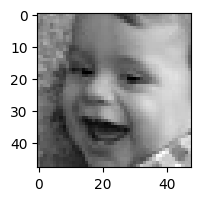

In [17]:
plt.figure(figsize=(2,2))
img = cv2.imread('dataset/train/happy/happy_train_3.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
img_size = img.shape
print('Image size: ',img_size)

In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = img_size
CHANNELS=3
EPOCHS=50

print(f'Batch size: {BATCH_SIZE}')
print(f'Image size: {IMAGE_SIZE}')
print(f'Channels: {CHANNELS}')
print(f'Epochs: {EPOCHS}')

Batch size: 32
Image size: (48, 48)
Channels: 3
Epochs: 50


In [23]:
transform = transforms.Compose([
    transforms.Resize(img_size),  # Resize to 48x48
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()  # Convert to tensor
])


In [25]:
train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('dataset/test', transform=transform)

In [26]:
class_names = train_dataset.classes
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [27]:
train_dataset.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [28]:
type(train_dataset)

torchvision.datasets.folder.ImageFolder

In [29]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [30]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [32]:
img, label = next(iter(train_dataloader))

In [33]:
img.shape

torch.Size([32, 1, 48, 48])

In [40]:
img[0].numpy()

array([[[0.2       , 0.21176471, 0.19607843, ..., 0.6       ,
         0.6       , 0.6       ],
        [0.19215687, 0.20784314, 0.19215687, ..., 0.6       ,
         0.6       , 0.6       ],
        [0.19215687, 0.21176471, 0.18431373, ..., 0.6       ,
         0.6       , 0.6       ],
        ...,
        [0.47058824, 0.3372549 , 0.42745098, ..., 0.5882353 ,
         0.5686275 , 0.5803922 ],
        [0.41960785, 0.45490196, 0.5137255 , ..., 0.5921569 ,
         0.5803922 , 0.60784316],
        [0.30588236, 0.39607844, 0.49411765, ..., 0.61960787,
         0.62352943, 0.67058825]]], dtype=float32)

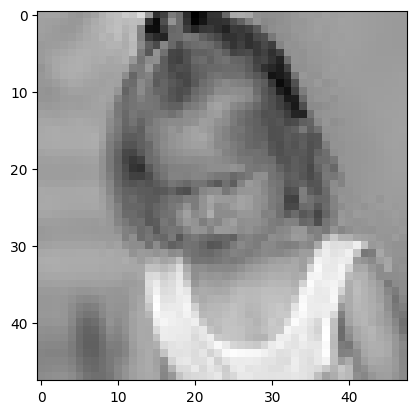

In [45]:
plt.imshow(img[2].numpy().transpose(1,2,0), cmap='gray')

In [37]:
label.numpy

<function Tensor.numpy>

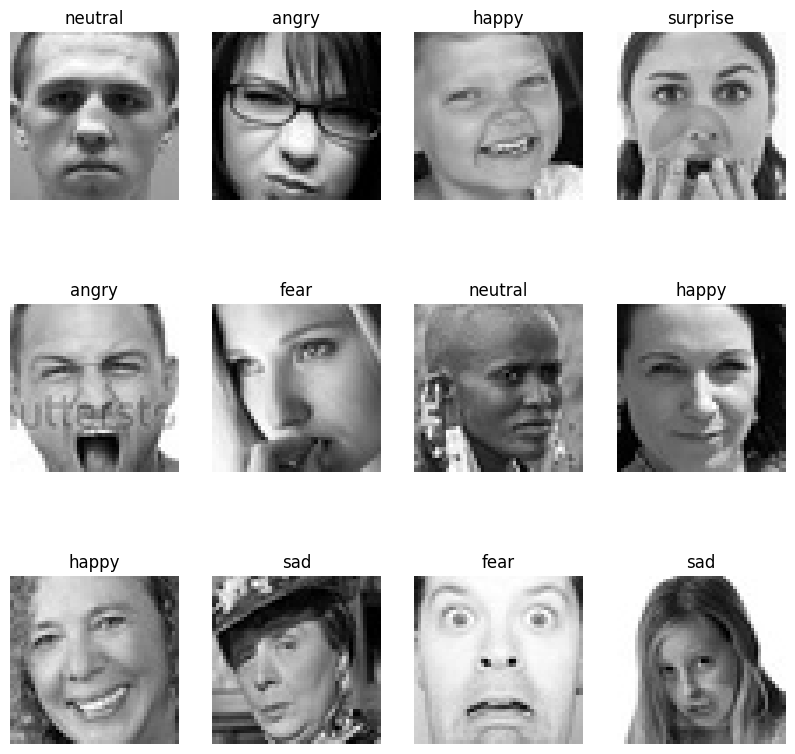

In [48]:
plt.figure(figsize=(10, 10))
for img, label in iter(train_dataloader):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(img[i].numpy().transpose(1,2,0), cmap='gray')
        plt.title(class_names[label[i]])
        plt.axis("off")
    break

In [110]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, n_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        # Adjusted fully connected layer input size for 48x48 image
        self.fc1 = nn.Linear(64 * 1 * 1, 64)  
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: 23x23
        x = self.pool(F.relu(self.conv2(x)))  # Output: 10x10
        x = self.pool(F.relu(self.conv3(x)))  # Output: 4x4
        x = self.pool(F.relu(self.conv4(x)))  # Output: 2x2
        x = self.pool(F.relu(self.conv5(x)))  # Output: 1x1
        x = self.flatten(x)                   # Flatten to (BATCH_SIZE, 64)
        x = F.relu(self.fc1(x))               # Fully connected layer
        x = F.softmax(self.fc2(x), dim=1)     # Output layer with softmax
        return x

# Example of how to instantiate the model
model = CNNModel(n_classes=7)

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [112]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

CUDA is available!  Training on GPU ...


In [113]:
# loss function and optimizer
# criterion = nn.NLLLoss()
# optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [114]:
from torch.autograd import Variable

In [115]:
# number of epochs to train the model
n_epochs = 50
loss_array = []
accuracy_array = []

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    train_accuracy = 0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_dataloader:
        if train_on_gpu:
            data, target = Variable(data.cuda()), Variable(target.cuda())
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        #calculate accuracy
        ps = torch.exp(output)
        
        top_p, top_class = ps.topk(1, dim=1)
        # print(top_class)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
# calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    loss_array.append(train_loss)
    accuracy_array.append(round(train_accuracy/len(train_dataloader),3))

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1, 
            train_loss
            ))
    print(f"Train accuracy: {train_accuracy/len(train_dataloader):.3f}")

Epoch: 1 	Training Loss: 1.718682
Train accuracy: 0.301
Epoch: 2 	Training Loss: 1.471751
Train accuracy: 0.430
Epoch: 3 	Training Loss: 1.371266
Train accuracy: 0.477
Epoch: 4 	Training Loss: 1.301171
Train accuracy: 0.505
Epoch: 5 	Training Loss: 1.257299
Train accuracy: 0.526
Epoch: 6 	Training Loss: 1.221659
Train accuracy: 0.536
Epoch: 7 	Training Loss: 1.182571
Train accuracy: 0.556
Epoch: 8 	Training Loss: 1.159686
Train accuracy: 0.565
Epoch: 9 	Training Loss: 1.135820
Train accuracy: 0.571
Epoch: 10 	Training Loss: 1.113126
Train accuracy: 0.583
Epoch: 11 	Training Loss: 1.092655
Train accuracy: 0.591
Epoch: 12 	Training Loss: 1.077509
Train accuracy: 0.597
Epoch: 13 	Training Loss: 1.056028
Train accuracy: 0.604
Epoch: 14 	Training Loss: 1.041532
Train accuracy: 0.611
Epoch: 15 	Training Loss: 1.021875
Train accuracy: 0.619
Epoch: 16 	Training Loss: 1.002687
Train accuracy: 0.622
Epoch: 17 	Training Loss: 0.992277
Train accuracy: 0.631
Epoch: 18 	Training Loss: 0.971495
Train

In [117]:
[i for i in range(n_epochs)]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

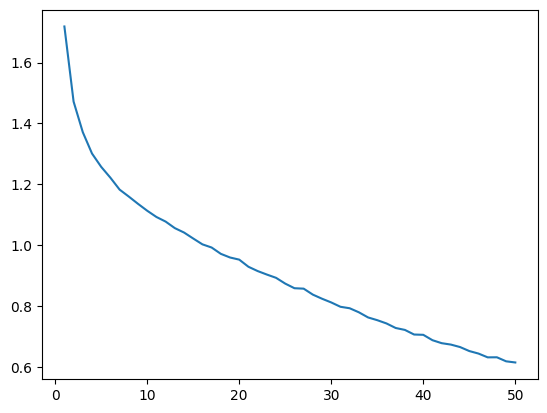

In [118]:
import matplotlib.pyplot as plt

plt.plot([i+1 for i in range(n_epochs)], loss_array)

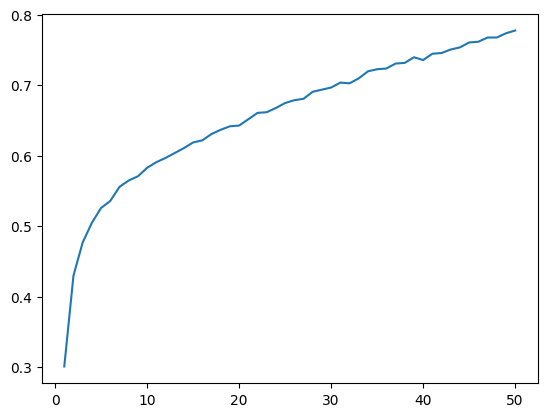

In [119]:
plt.plot([i+1 for i in range(n_epochs)], accuracy_array)

In [122]:
test_accuracy = 0
model.eval() # prep model for evaluation
for data, target in test_dataloader:
    if train_on_gpu:
        data, target = Variable(data.cuda()), Variable(target.cuda())
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    #calculate accuracy
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test accuracy: {test_accuracy/len(test_dataloader):.3f}")

Test accuracy: 0.626
